# NLP Clissification
---
**Dataset:** bbc news (250 samples) News contents with 5 categories (Sport, Business, Politics, Tech and Others)

**Model:**   multiclass classification model : ELMO

**Training:**  Colab (GPU)  tensorflow version : 1.14.0  keras version : 2.2.4

**Process:**  1. Dataset Load  ➔ 2. Data processing ➔ 3. Model Training  ➔ 4. Model Evaluation 

**Result:**  Accuracy = 0.94, Run time  1 minute


## 0. Environment

In [0]:
# Based Library
import tensorflow as tf; print("tensorflow version : " + tf.__version__)
import keras; print("keras version : " + keras.__version__)

tensorflow version : 1.14.0
keras version : 2.2.4


Using TensorFlow backend.


In [0]:
# Processor

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3126358605766770946
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13535383898260880840
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9458942468859749678
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14655255348
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3802176377223122401
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


## 1. Dataset Load

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd

input_file = "/content/drive/My Drive/dataset/bbc/bbc-text250.csv"

data=pd.read_csv(input_file)

In [0]:
data.head()

,category,text
0,business,worldcom boss left books alone former worldc...
1,business,virgin blue shares plummet 20% shares in austr...
2,business,crude oil prices back above $50 cold weather a...
3,business,s korean credit card firm rescued south korea ...
4,business,japanese banking battle at an end japan s sumi...


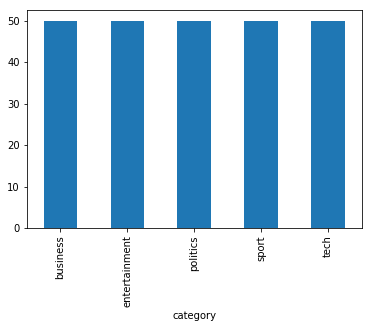

In [0]:
import matplotlib.pyplot as plt

data.groupby('category').text.count().plot.bar(ylim=0)
plt.show()

## 2. Data Processing

In [0]:
from sklearn.preprocessing import LabelEncoder

df = pd.DataFrame()
df["text"] = data["text"]
df["label"] = LabelEncoder().fit_transform(data["category"])

In [0]:
df.head()

,text,label
0,worldcom boss left books alone former worldc...,0
1,virgin blue shares plummet 20% shares in austr...,0
2,crude oil prices back above $50 cold weather a...,0
3,s korean credit card firm rescued south korea ...,0
4,japanese banking battle at an end japan s sumi...,0


In [0]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
df.head()

,text,label
0,worldcom boss left books alone former worldcom...,0
1,virgin blue shares plummet 20% shares australi...,0
2,crude oil prices back $50 cold weather across ...,0
3,korean credit card firm rescued south korea la...,0
4,japanese banking battle end japan sumitomo mit...,0


In [0]:
freq = pd.Series(' '.join(df['text']).split()).value_counts()[-10:]
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

In [0]:
df.head()

,text,label
0,worldcom boss left books alone former worldcom...,0
1,virgin blue shares plummet 20% shares australi...,0
2,crude oil prices back $50 cold weather across ...,0
3,korean credit card firm rescued south korea la...,0
4,japanese banking battle end japan sumitomo mit...,0


In [0]:
import pandas as pd
import numpy as np
import spacy
from tqdm import tqdm
import re
import time
import pickle
pd.set_option('display.max_colwidth', 200)

In [0]:
import tensorflow_hub as hub
import tensorflow as tf

embed = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

In [0]:
%time
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn import preprocessing
import keras
import numpy as np

x = list(df['text'])
y = list(df['label'])

le = preprocessing.LabelEncoder()
le.fit(y)

def encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def decode(le, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return le.inverse_transform(dec)

x_enc = x
y_enc = encode(le, y)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(np.asarray(x_enc), np.asarray(y_enc), test_size=0.2, random_state=42)

print("x_train count : ", len(x_train))
print("x_test count : ", len(x_test))

x_train count :  200
x_test count :  50


## 3. Model Training

In [0]:
from datetime import datetime
from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K

start_time = datetime.now()

def ELMoEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
dense = Dense(256, activation='relu')(embedding)
pred = Dense(5, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model.fit(x_train, y_train, epochs=1, batch_size=16)
    model.save_weights('./elmo-model.h5')

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('./elmo-model.h5')  
    predicts = model.predict(x_test, batch_size=16)

y_test = decode(le, y_test)
y_preds = decode(le, predicts)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

W0715 16:03:34.074509 139821235160960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0715 16:03:34.075975 139821235160960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0715 16:03:34.393755 139821235160960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0715 16:03:34.559335 139821235160960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0715 16:03:34.581817 139821235160960 deprecation_wrappe

Epoch 1/1
200/200 [==============================] - 24s 120ms/step - loss: 0.8678 - acc: 0.7350
Duration: 0:00:32.350509


## 4. Model Evaluation

In [0]:
from sklearn import metrics

print(metrics.confusion_matrix(y_test, y_preds))

print(metrics.classification_report(y_test, y_preds))

from sklearn.metrics import accuracy_score

print("Accuracy of ELMO is:",accuracy_score(y_test,y_preds))

[[13  0  0  0  0]
 [ 0  7  0  0  0]
 [ 0  1  9  0  0]
 [ 0  0  0 11  0]
 [ 1  0  1  0  7]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       0.88      1.00      0.93         7
           2       0.90      0.90      0.90        10
           3       1.00      1.00      1.00        11
           4       1.00      0.78      0.88         9

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.93        50
weighted avg       0.94      0.94      0.94        50

Accuracy of ELMO is: 0.94
